In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from evcouplings.couplings import read_raw_ec_file
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams['font.family'] = 'Arial'

In [8]:
data_root = Path("../data")

In [2]:
# Bae and Phillips 2005, https://doi.org/10.1073/pnas.0507527103
# AMPbind (residues 31–60) 
# LID (residues 127–164)
# CORE (residues 1–30, 61–126, and 165–217) 

# convert to zero index
core_idx = [(0, 29), (60, 125), (164, 216)]
core_idxs = []
for start, end in core_idx:
    core_idxs.extend(list(range(start, end + 1)))
    
amp_idx = [(30, 59)]
amp_idxs = []
for start, end in amp_idx:
    amp_idxs.extend(list(range(start, end + 1)))

lid_idx = [(126, 163)]
lid_idxs = []
for start, end in lid_idx:
    lid_idxs.extend(list(range(start, end + 1)))

In [10]:
ecs = read_raw_ec_file(data_root / "plmc/adk_175_org_bs_focus.EC")

# sort by i
ecs = ecs.sort_values(by=["i", "j"])

# map to bsADK residue numbering
bs_idx_mapping_i = {k:l for k, l in zip(ecs["i"].unique(), range(1,len(ecs["i"].unique())+2))}
bs_idx_mapping_j = {k:l for k, l in zip(ecs["j"].unique(), range(2, len(ecs["j"].unique())+3))}
ecs["i"] = ecs["i"].map(bs_idx_mapping_i)
ecs["j"] = ecs["j"].map(bs_idx_mapping_j)

# create matrix
ec_matrix = pd.DataFrame(index=ecs["i"].unique(), columns=ecs["j"].unique())
for i, j, coupling_score in zip(ecs["i"], ecs["j"], ecs["cn"]):
    ec_matrix.at[i, j] = coupling_score

# add a nan column to front and nan row to bottom to complete diagonal
ec_matrix.insert(0, "1", [float('nan')]*len(ec_matrix))
ec_matrix.loc[len(ec_matrix)+1] = [float('nan')] * len(ec_matrix.columns)

ec_arr = ec_matrix.to_numpy()
ec_arr = ec_arr.astype(float)

# set below diagonal to zero
ec_arr = np.triu(ec_arr, k=1)
# reflect across diagonal
ec_arr = ec_arr + ec_arr.T
# set diagonal to nan
np.fill_diagonal(ec_arr, float('nan'))

In [11]:
big_msa_ecs = read_raw_ec_file(data_root / "plmc/big_adk_bs_focus.EC")

# sort by i
big_msa_ecs = big_msa_ecs.sort_values(by=["i", "j"])

# map to bsADK residue numbering
bs_idx_mapping_i = {k:l for k, l in zip(big_msa_ecs["i"].unique(), range(1,len(big_msa_ecs["i"].unique())+2))}
bs_idx_mapping_j = {k:l for k, l in zip(big_msa_ecs["j"].unique(), range(2, len(big_msa_ecs["j"].unique())+3))}
big_msa_ecs["i"] = big_msa_ecs["i"].map(bs_idx_mapping_i)
big_msa_ecs["j"] = big_msa_ecs["j"].map(bs_idx_mapping_j)

# create matrix
big_msa_ec_matrix = pd.DataFrame(index=big_msa_ecs["i"].unique(), columns=big_msa_ecs["j"].unique())
for i, j, coupling_score in zip(big_msa_ecs["i"], big_msa_ecs["j"], big_msa_ecs["cn"]):
    big_msa_ec_matrix.at[i, j] = coupling_score

# add a nan column to front and nan row to bottom to complete diagonal
big_msa_ec_matrix.insert(0, "1", [float('nan')]*len(big_msa_ec_matrix))
big_msa_ec_matrix.loc[len(big_msa_ec_matrix)+1] = [float('nan')] * len(big_msa_ec_matrix.columns)

big_msa_ec_arr = big_msa_ec_matrix.to_numpy()
big_msa_ec_arr = big_msa_ec_arr.astype(float)

# set below diagonal to zero
big_msa_ec_arr = np.triu(big_msa_ec_arr, k=1)
# reflect across diagonal
big_msa_ec_arr = big_msa_ec_arr + big_msa_ec_arr.T
# set diagonal to nan
np.fill_diagonal(big_msa_ec_arr, float('nan'))

In [12]:
domain_idxs = [core_idxs, amp_idxs, lid_idxs]
domain_coupling_175_arr_max = np.zeros((len(domain_idxs), len(domain_idxs)))
domain_coupling_175_arr_mean = np.zeros((len(domain_idxs), len(domain_idxs)))
domain_coupling_5149_arr_max = np.zeros((len(domain_idxs), len(domain_idxs)))
domain_coupling_5149_arr_mean = np.zeros((len(domain_idxs), len(domain_idxs)))

# compute inter and intro domain coupling
for f in range(len(domain_idxs)):
    for g in range(len(domain_idxs)):
        sub_arr = ec_arr[domain_idxs[f], :][:, domain_idxs[g]]
        domain_coupling_175_arr_max[f, g] = np.nanmax(sub_arr,)
        domain_coupling_175_arr_mean[f, g] = np.nanmean(sub_arr)    
        big_sub_arr = big_msa_ec_arr[domain_idxs[f], :][:, domain_idxs[g]]
        domain_coupling_5149_arr_max[f, g] = np.nanmax(big_sub_arr)
        domain_coupling_5149_arr_mean[f, g] = np.nanmean(big_sub_arr)      

In [13]:
domain_labels = ["CORE", "AMP", "LID"]

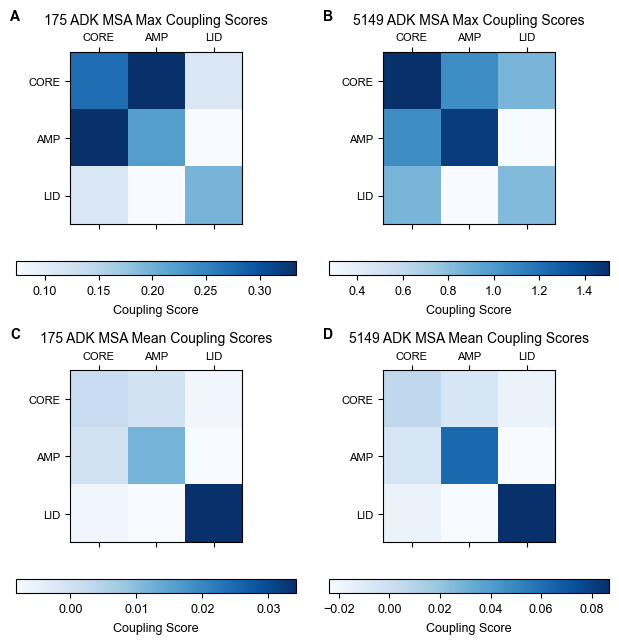

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 6.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


axs[0, 0].matshow(domain_coupling_175_arr_max, cmap="Blues")
axs[0, 0].set_xticks(range(len(domain_labels)))
axs[0, 0].set_yticks(range(len(domain_labels)))
axs[0, 0].set_xticklabels(domain_labels)
axs[0, 0].set_yticklabels(domain_labels)
axs[0, 0].set_title("175 ADK MSA Max Coupling Scores", fontsize=10)
# add colorbar
cbar = plt.colorbar(axs[0, 0].get_children()[0], ax=axs[0, 0], location="bottom")
cbar.set_label("Coupling Score", labelpad=5)


axs[0, 1].matshow(domain_coupling_5149_arr_max, cmap="Blues")
axs[0, 1].set_xticks(range(len(domain_labels)))
axs[0, 1].set_yticks(range(len(domain_labels)))
axs[0, 1].set_xticklabels(domain_labels)
axs[0, 1].set_yticklabels(domain_labels)
axs[0, 1].set_title("5149 ADK MSA Max Coupling Scores", fontsize=10)
cbar = plt.colorbar(axs[0, 1].get_children()[0], ax=axs[0, 1], location="bottom")
cbar.set_label("Coupling Score", labelpad=5)


axs[1, 0].matshow(domain_coupling_175_arr_mean, cmap="Blues")
axs[1, 0].set_xticks(range(len(domain_labels)))
axs[1, 0].set_yticks(range(len(domain_labels)))
axs[1, 0].set_xticklabels(domain_labels)
axs[1, 0].set_yticklabels(domain_labels)
axs[1, 0].set_title("175 ADK MSA Mean Coupling Scores", fontsize=10)
# add colorbar
cbar = plt.colorbar(axs[1, 0].get_children()[0], ax=axs[1, 0], location="bottom")
cbar.set_label("Coupling Score", labelpad=5)


axs[1, 1].matshow(domain_coupling_5149_arr_mean, cmap="Blues")
axs[1, 1].set_xticks(range(len(domain_labels)))
axs[1, 1].set_yticks(range(len(domain_labels)))
axs[1, 1].set_xticklabels(domain_labels)
axs[1, 1].set_yticklabels(domain_labels)
axs[1, 1].set_title("5149 ADK MSA Mean Coupling Scores", fontsize=10)
# add colorbar
cbar = plt.colorbar(axs[1, 1].get_children()[0], ax=axs[1, 1], location="bottom")
cbar.set_label("Coupling Score", labelpad=5)
for ax, label in zip(axs.flat, ["A", "B", "C", "D"]):
    ax.tick_params(labelsize=8)
    ax.text(-0.35, 1.25, label, transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='left')
plt.tight_layout()
plt.show()